In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim)
        )

    def forward(self, x):
        return x + self.block(x)

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [4]:
class ResNetGenerator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_blocks, output_dim=50, num_choices=50):
        super(ResNetGenerator, self).__init__()
        self.initial_mlp = MLP(input_dim, hidden_dim, hidden_dim)
        self.resnet_blocks = nn.Sequential(*[ResidualBlock(hidden_dim) for n in range(num_blocks)])
        self.final_mlp = MLP(hidden_dim, hidden_dim, output_dim * num_choices)

        self.coordinates_range = torch.linspace(0.1, 0.6, output_dim)

        self.num_choices = num_choices

        # Hyperparamters
        self.alpha = 0.001
        self.alpha_sup = 0.01

    def update_alpha(self, normIter):
        self.alpha = (normIter/0.05) * self.alpha_sup + 1
        return self.alpha
    
    def forward(self, z, alpha):
        x = self.initial_mlp(z)
        x = self.resnet_blocks(x)
        x = self.final_mlp(x)
        
        # Reshape the output into [batch_size, 50, num_choices]
        coordinates = x.view(-1, 50, self.num_choices)  # [batch_size, 50, 50]

        # Apply softmax to generate a distribution over the choices
        coordinates = F.softmax(coordinates * alpha, dim=-1)

        # Perform the weighted sum over the predefined range
        predicted_coords = torch.sum(coordinates * self.coordinates_range, dim=-1)  # [batch_size, 50]
        
        return predicted_coords

In [5]:
#Lumerical PyTorch Wrapper requires 4 things:
#1. Implementation of forward()
#2. Calling methods in the ctx arguments
#3. Declare if the function supports double backward
#4. Validate if gradients are correct


#
class Lumerical_Wrapper(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx,grating_params):
        #Rum Lumerical adjoint method here using grating params
        fom=torch.from_numpy(np.loadtxt('fom.csv',delimiter=','))
        return fom
    
    @staticmethod
    def backward(ctx,grad_out):
        gradient=torch.from_numpy(np.loadtxt('gradient.csv',delimiter=','))
        return grad_out*gradient
    
def lumerical_grad_pytorch(x):
    result=Lumerical_Wrapper.apply(x)
    return result

# grating_parameters=torch.from_numpy(np.loadtxt('params.csv',delimiter=','))
#grating_parameters = predicted_coords
#grating_parameters=grating_parameters.requires_grad_()
#loss=lumerical_grad_pytorch(torch.cos(torch.tensor(10.0))*grating_parameters)
#loss.backward()

# optimizer.zero_grad()   <- set gradient to zero
# loss.backward()   <- compute gradient
# optimizer.step()  <- gradient descent

In [6]:
import importlib
import FDTD_Simulation

importlib.reload(FDTD_Simulation)

from FDTD_Simulation import FDTD_Simulation

CONFIGURATION FILE {'root': 'C:\\Program Files\\Lumerical\\v232\\api\\python', 'lumapi': 'C:\\Program Files\\Lumerical\\v232\\api\\python\\'}


Accurate interface detection enabled


C:\Program Files\Lumerical\v232\api\python\lumopt\utilities\plotter.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


Running scipy optimizer
bounds = [[-3.   3. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]]
start = [0.35118723 0.35924512 0.34876123 0.34850949 0.34850681 0.34461486
 0.3479844  0.35323706 0.34836346 0.34996298 0.34693605 0.34852022
 0.3508133  0.34885007 0.34871489 0.34705284 0.35029286 0.35289532
 0.35868585 0.34031984 0.34616432 0.34108758 0.3459664  0.33844233
 0.35157761 0.35305229 0.35331288 0.3505

C:\Program Files\Lumerical\v232\api\python\lumopt\utilities\plotter.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


Running scipy optimizer
bounds = [[-3.   3. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]]
start = [0.35196429 0.35814631 0.35047302 0.35311687 0.35134679 0.34969971
 0.34891504 0.35512453 0.3472541  0.35433981 0.34294891 0.34835318
 0.35032153 0.35204968 0.34946433 0.34439468 0.34566694 0.34639004
 0.35254568 0.34954822 0.34613281 0.34825769 0.35180134 0.3443433
 0.34700468 0.35387313 0.35080266 0.35294

C:\Program Files\Lumerical\v232\api\python\lumopt\utilities\plotter.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


Running scipy optimizer
bounds = [[-3.   3. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]]
start = [0.35193482 0.36090606 0.34972245 0.36201683 0.3562361  0.34824044
 0.34682345 0.34931374 0.35391998 0.36095595 0.35388538 0.35500455
 0.35242164 0.35208026 0.35122657 0.34414035 0.34882319 0.35202551
 0.35078099 0.35077146 0.35523841 0.35173625 0.35168669 0.3384499
 0.3457008  0.35520253 0.36135554 0.33749

C:\Program Files\Lumerical\v232\api\python\lumopt\utilities\plotter.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


Running scipy optimizer
bounds = [[-3.   3. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]]
start = [0.34901333 0.34938264 0.35347953 0.35969368 0.35723364 0.3537311
 0.35619327 0.34907994 0.36369193 0.35770032 0.35264003 0.35549515
 0.35574847 0.35914549 0.35365725 0.34276861 0.34796783 0.34236646
 0.35091424 0.34801835 0.35588527 0.35632858 0.3496033  0.33849514
 0.34780395 0.35480869 0.35876444 0.34613

C:\Program Files\Lumerical\v232\api\python\lumopt\utilities\plotter.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


Running scipy optimizer
bounds = [[-3.   3. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]]
start = [0.35447276 0.35002151 0.34286445 0.36079103 0.35782877 0.35853344
 0.36100513 0.35601592 0.35950461 0.36096072 0.35562456 0.35822624
 0.3547217  0.36429688 0.36368281 0.33909455 0.34140071 0.34290686
 0.34926832 0.34857884 0.35873944 0.35667771 0.3481696  0.33380812
 0.34124616 0.35429698 0.36141211 0.3458

C:\Program Files\Lumerical\v232\api\python\lumopt\utilities\plotter.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


Running scipy optimizer
bounds = [[-3.   3. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]]
start = [0.35212317 0.36118904 0.34664783 0.3681733  0.35511407 0.35755748
 0.36358994 0.36527929 0.36354211 0.36123532 0.3566395  0.36169174
 0.36446145 0.3609814  0.36236477 0.33851978 0.33741257 0.33355296
 0.34410444 0.34327352 0.3572998  0.35919204 0.35361326 0.33196902
 0.33527204 0.36338854 0.37032413 0.3447

C:\Program Files\Lumerical\v232\api\python\lumopt\utilities\plotter.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


Running scipy optimizer
bounds = [[-3.   3. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]]
start = [0.35474634 0.3605307  0.34248999 0.3662715  0.36145961 0.35847551
 0.35826519 0.36033508 0.36294481 0.36843929 0.35294351 0.36054742
 0.35912266 0.35872689 0.3565295  0.33973497 0.33663762 0.33363354
 0.34241593 0.35422596 0.36624444 0.35169256 0.34725001 0.33556199
 0.33629048 0.35900915 0.36357862 0.3389

C:\Program Files\Lumerical\v232\api\python\lumopt\utilities\plotter.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


Running scipy optimizer
bounds = [[-3.   3. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]]
start = [0.35460135 0.35621667 0.34660611 0.36368999 0.36412019 0.35194412
 0.36460215 0.37528995 0.36601585 0.37047425 0.36981899 0.36790672
 0.36498344 0.36346835 0.3604326  0.33301342 0.33366144 0.33619955
 0.34340736 0.35789245 0.36684194 0.35817149 0.3510572  0.32327977
 0.34016258 0.36860052 0.37335533 0.3259

C:\Program Files\Lumerical\v232\api\python\lumopt\utilities\plotter.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


Running scipy optimizer
bounds = [[-3.   3. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]]
start = [0.35147256 0.35987976 0.34578383 0.36773646 0.37047264 0.3549583
 0.37565038 0.37253976 0.37594235 0.37358731 0.36690506 0.36608329
 0.36506686 0.36247656 0.35963833 0.32986271 0.33046427 0.33034593
 0.33449769 0.35938084 0.37028858 0.35249716 0.34226534 0.31573915
 0.33247304 0.37111098 0.37077817 0.32692

C:\Program Files\Lumerical\v232\api\python\lumopt\utilities\plotter.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


Running scipy optimizer
bounds = [[-3.   3. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]]
start = [0.35165319 0.36266407 0.34559545 0.36557847 0.37518567 0.36451644
 0.37695181 0.37032962 0.38150799 0.37866291 0.36934164 0.36971509
 0.36670968 0.36713099 0.3639273  0.3221643  0.31782344 0.31548738
 0.3261711  0.36447433 0.38246596 0.35156527 0.33475527 0.31637028
 0.32707921 0.3701649  0.37895471 0.3309

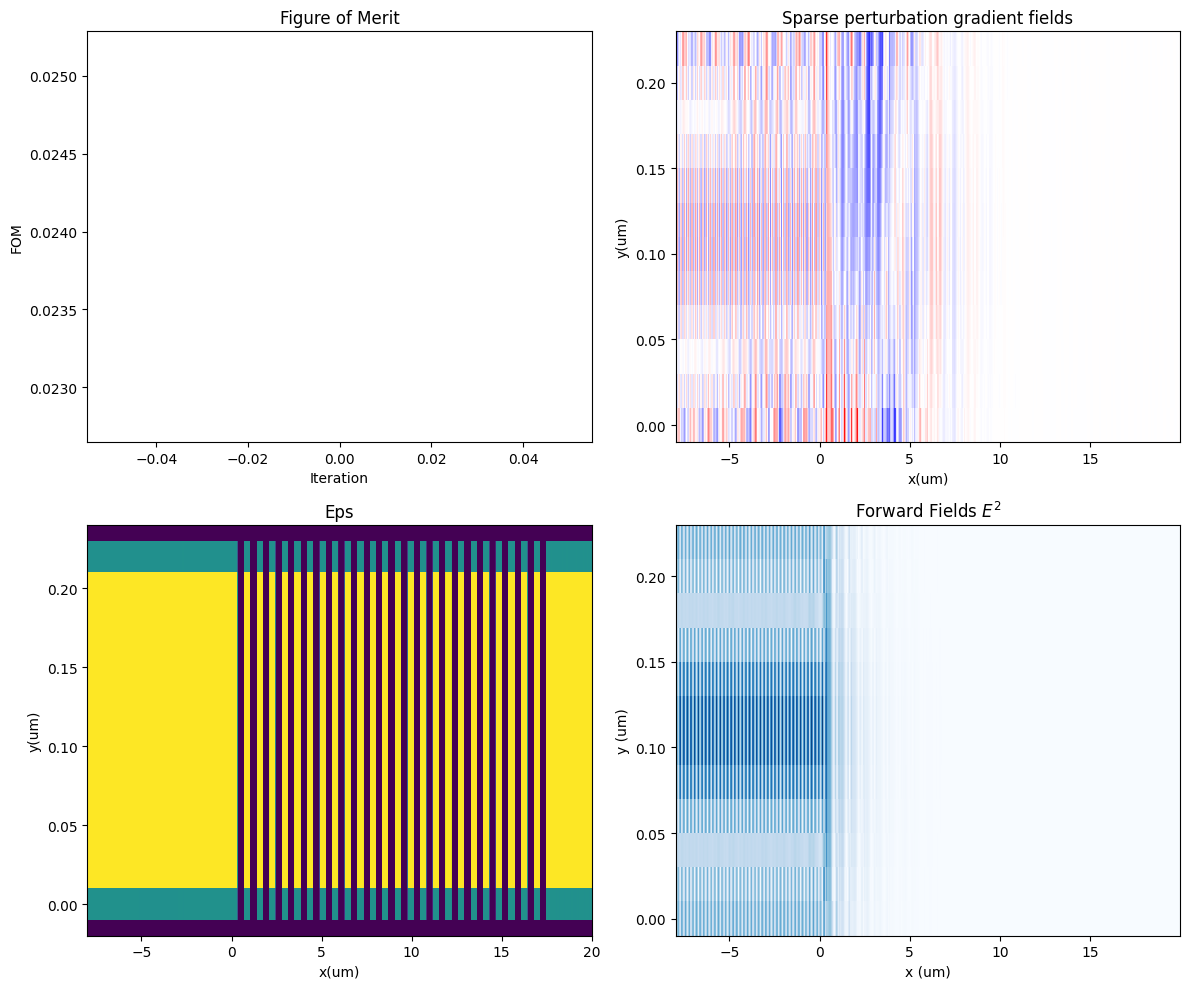

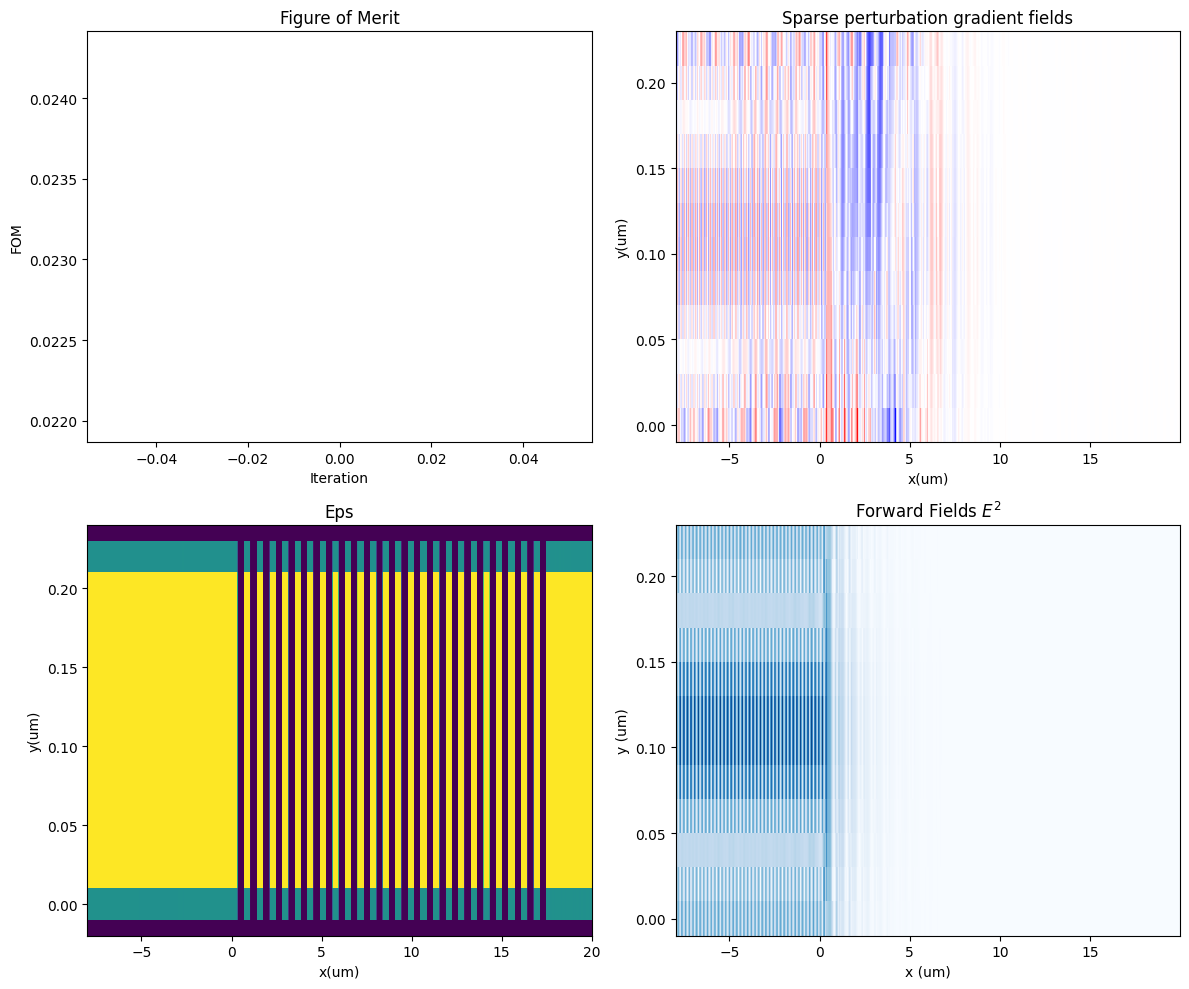

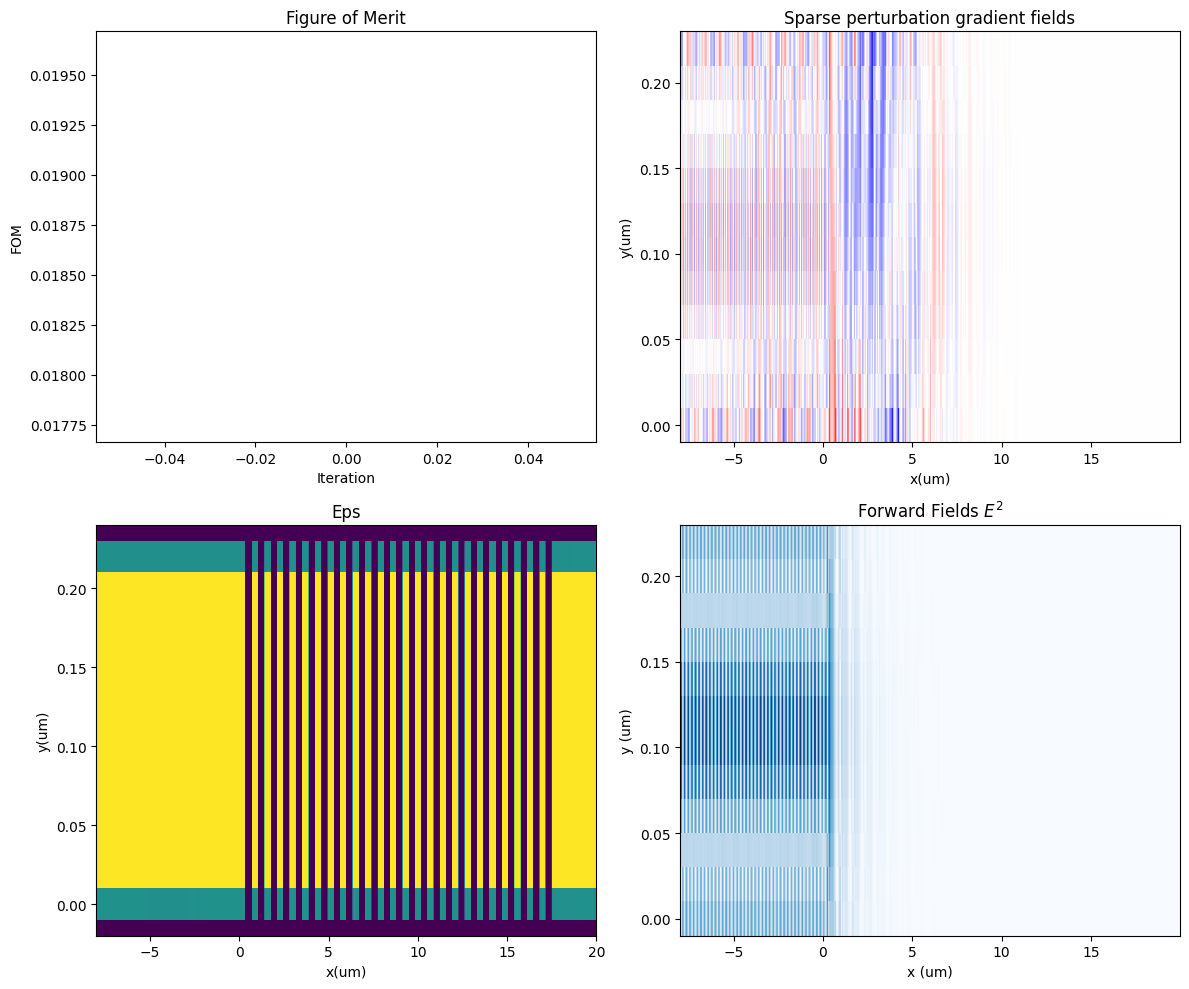

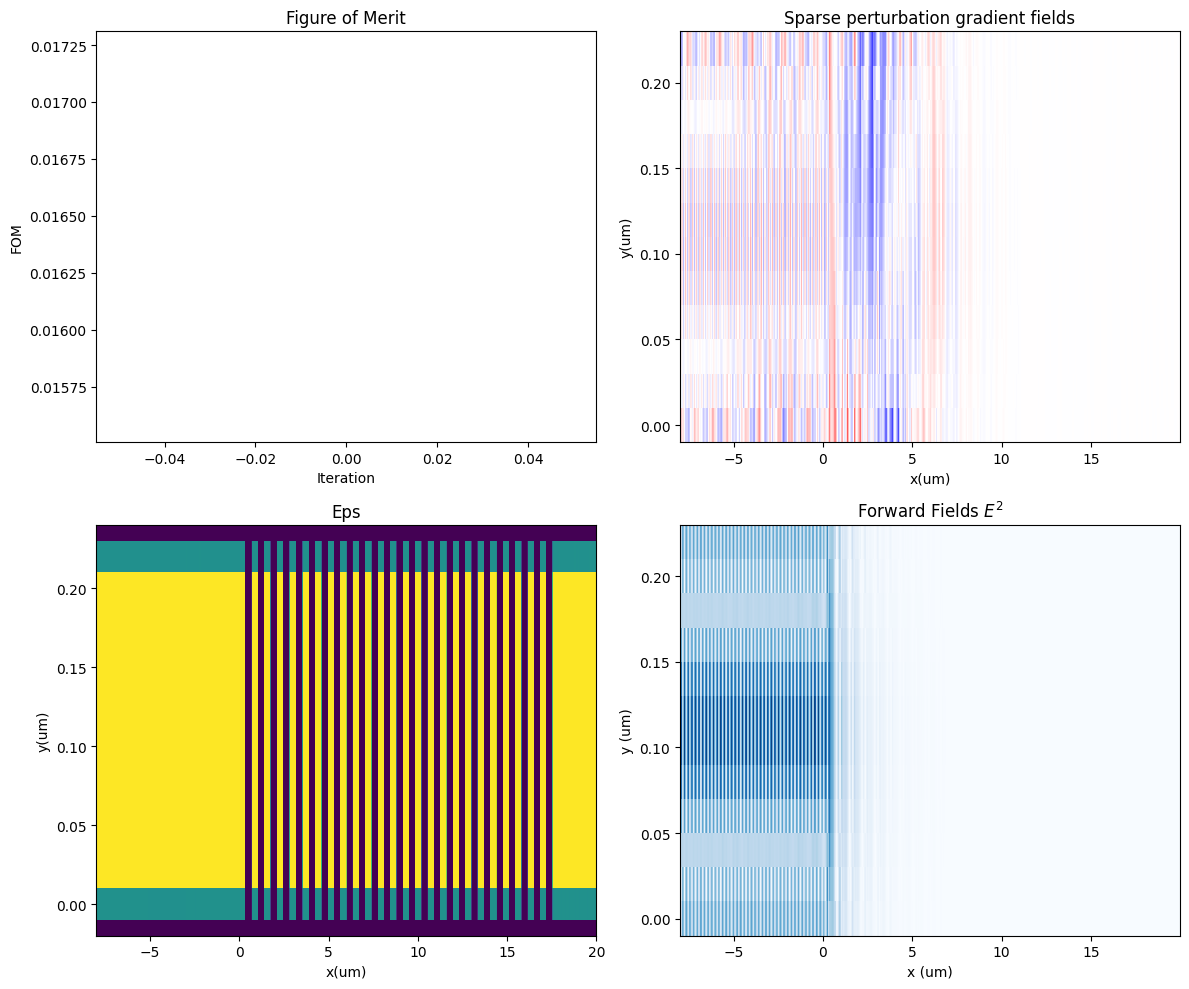

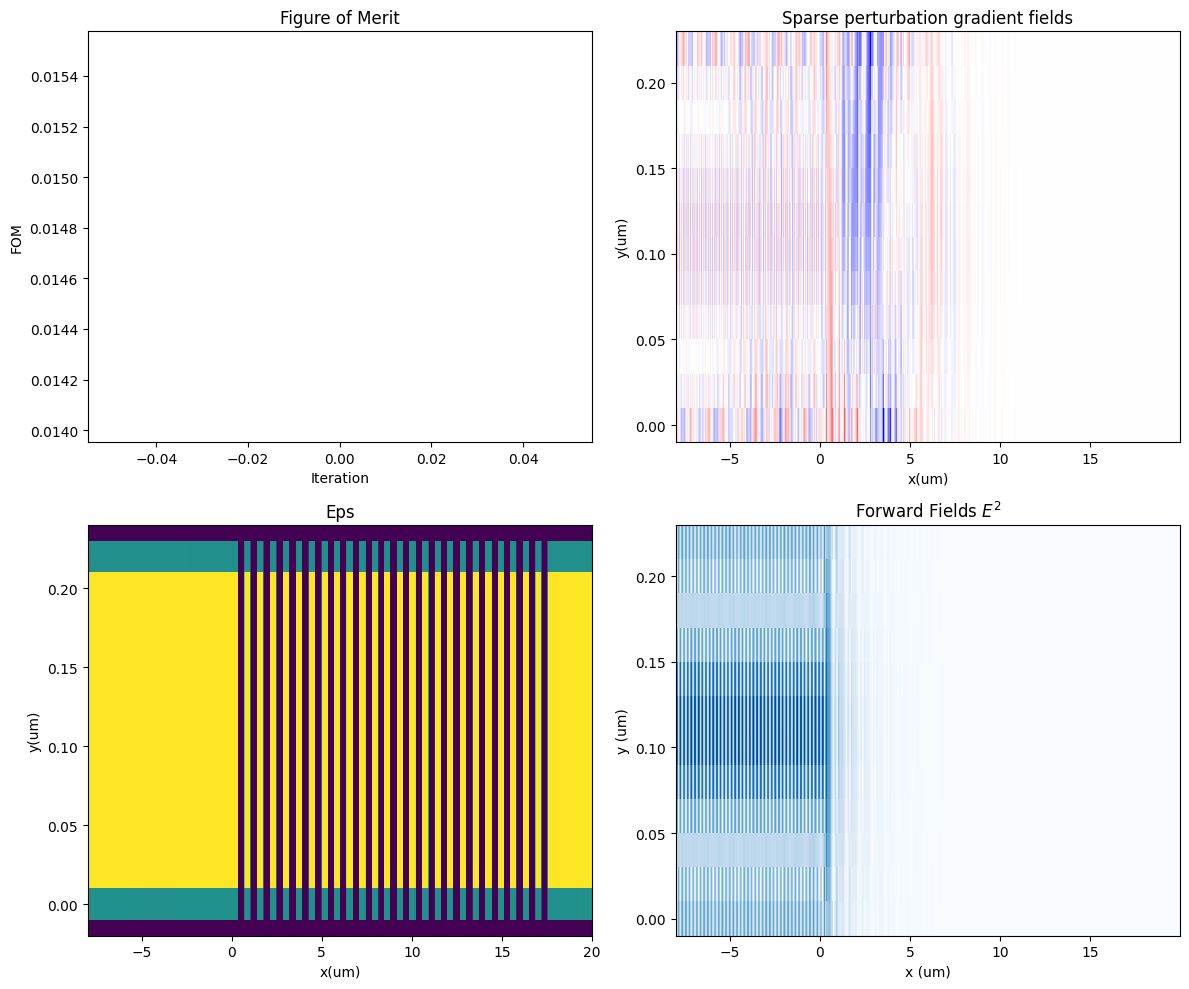

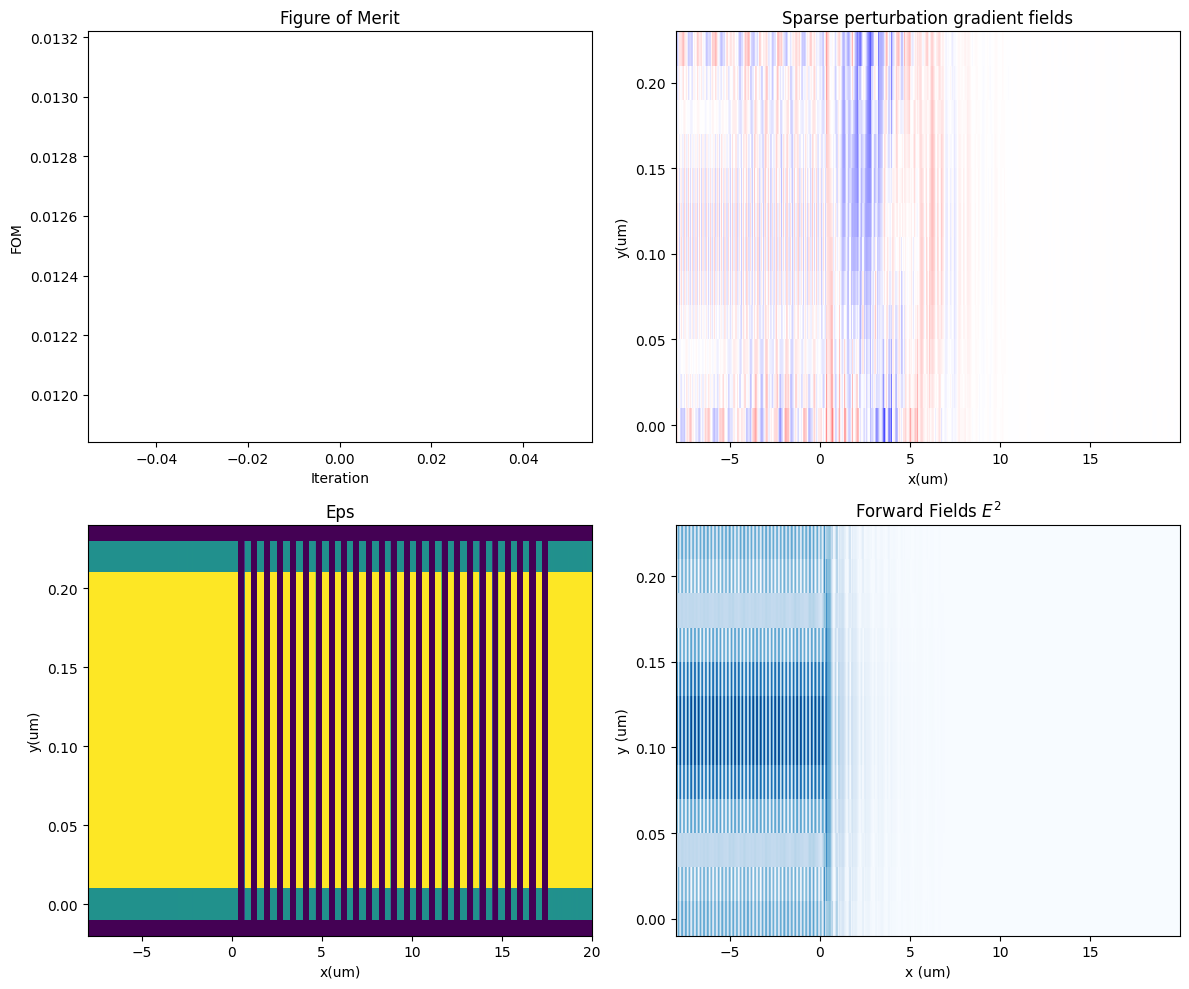

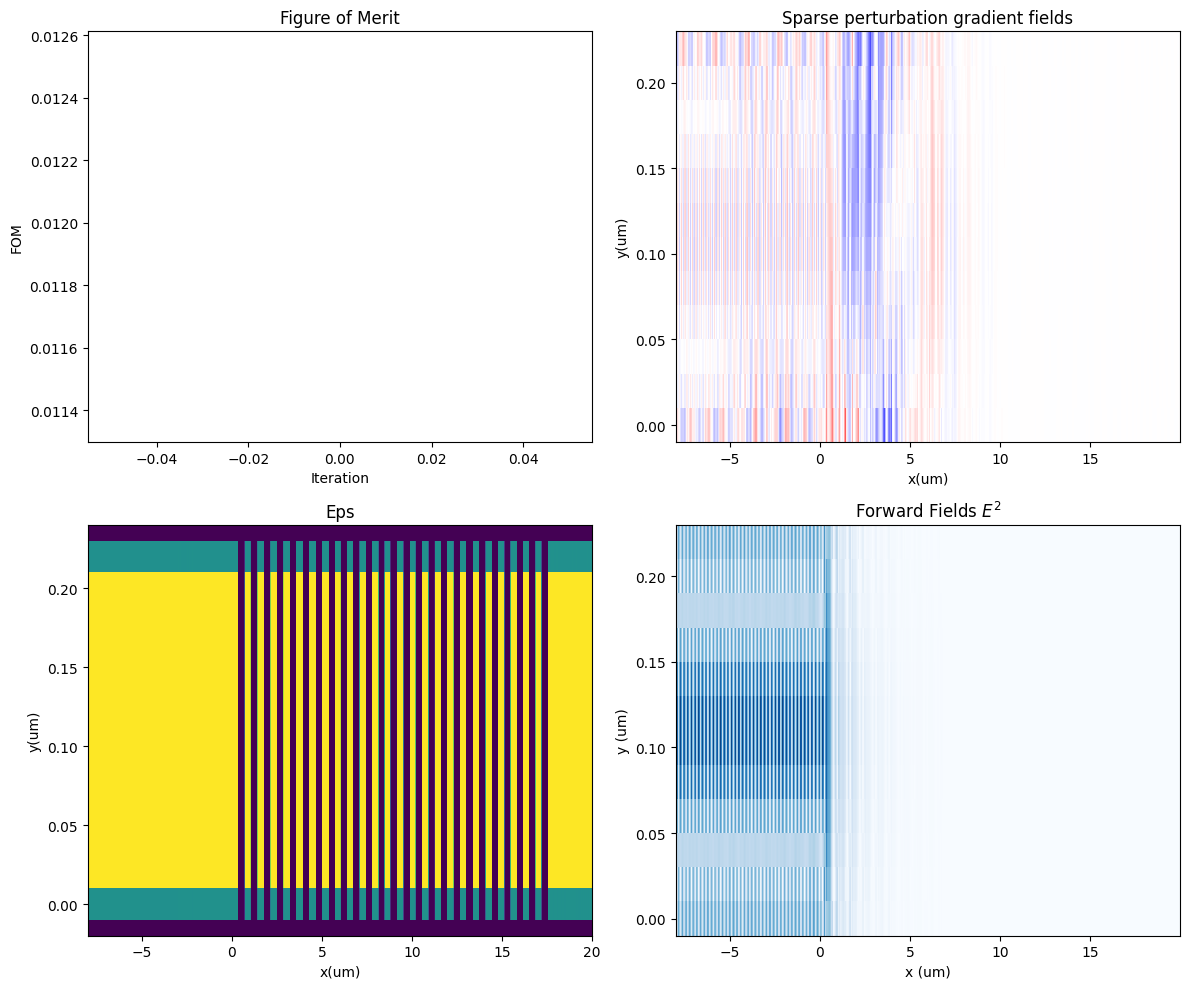

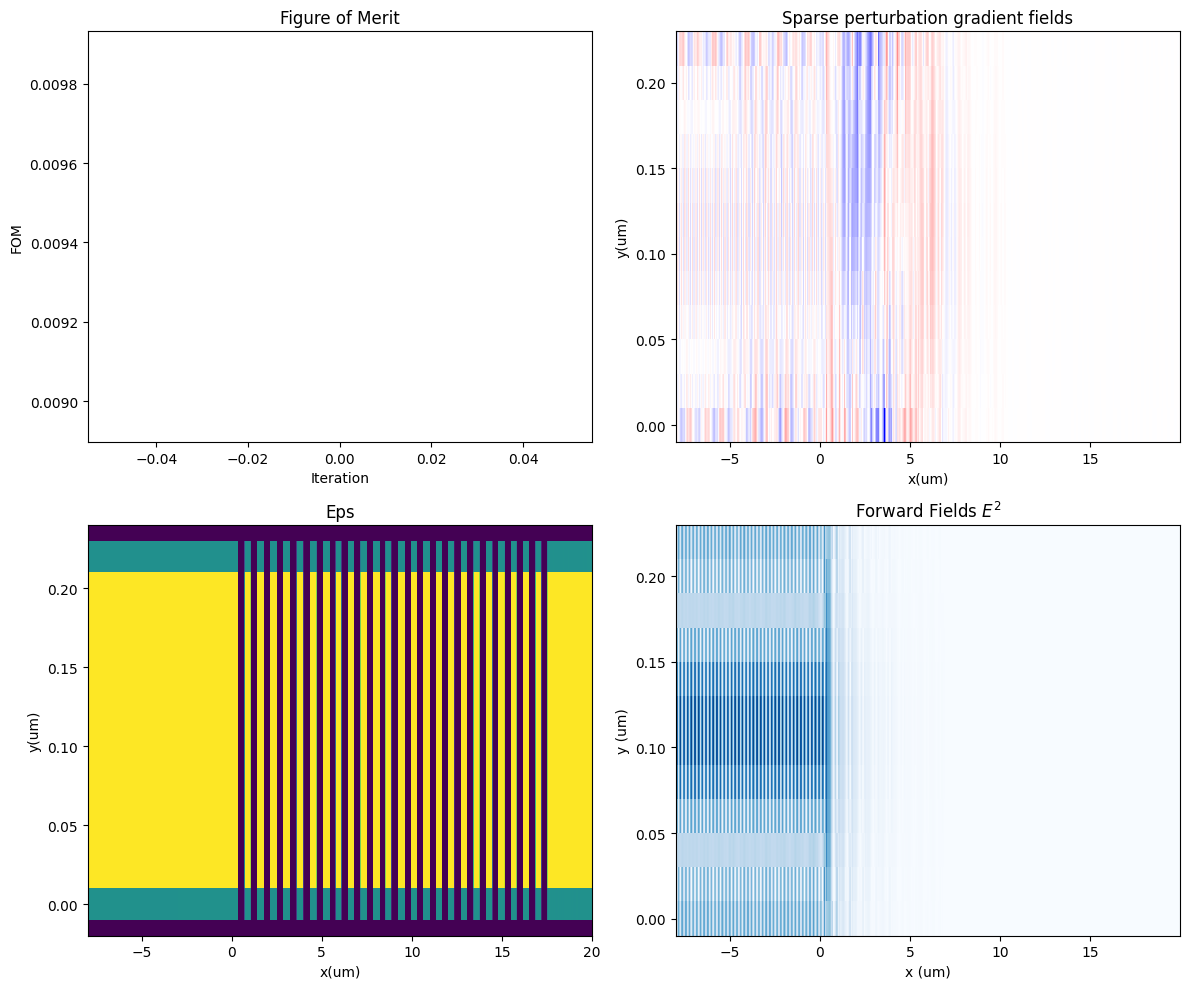

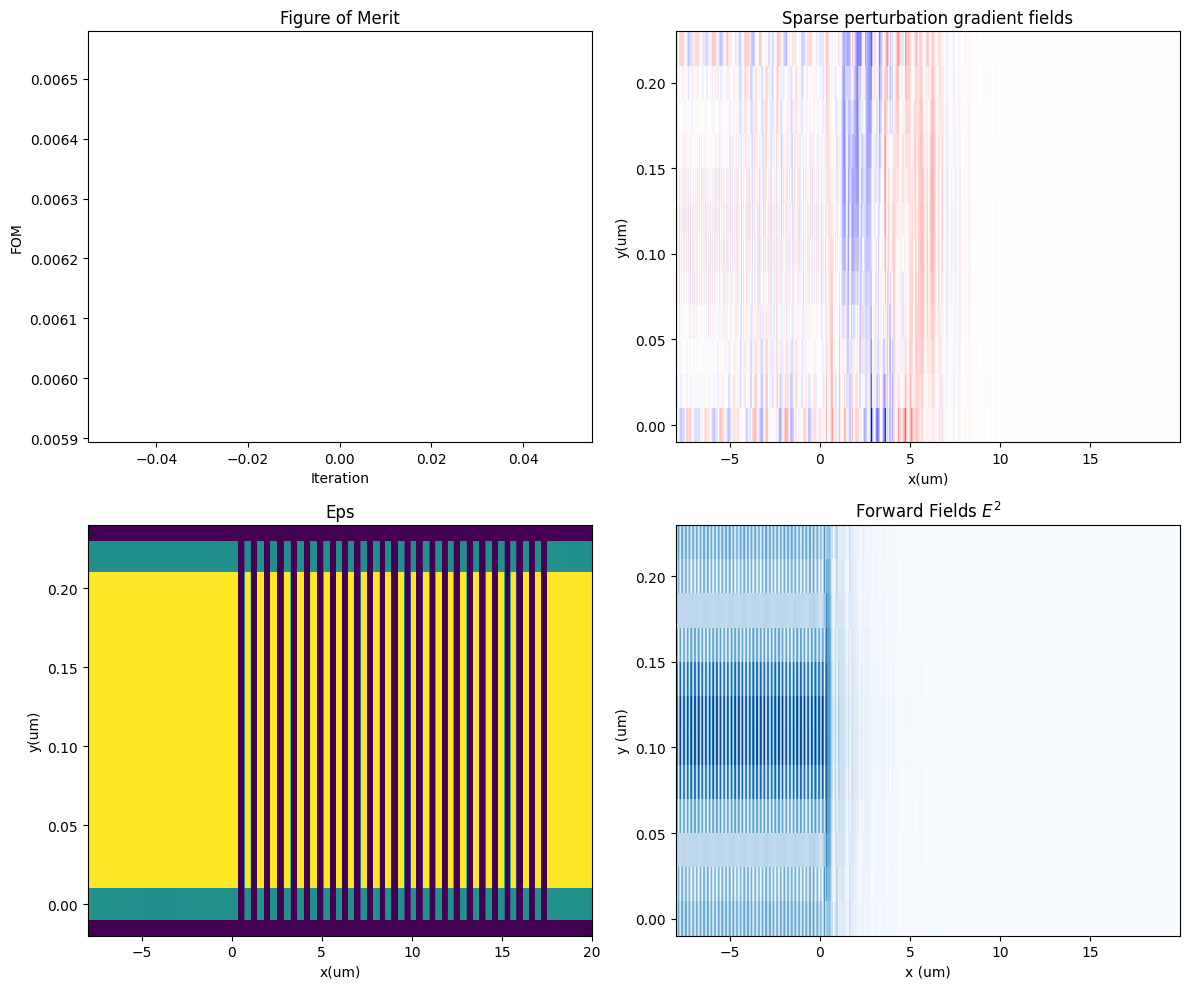

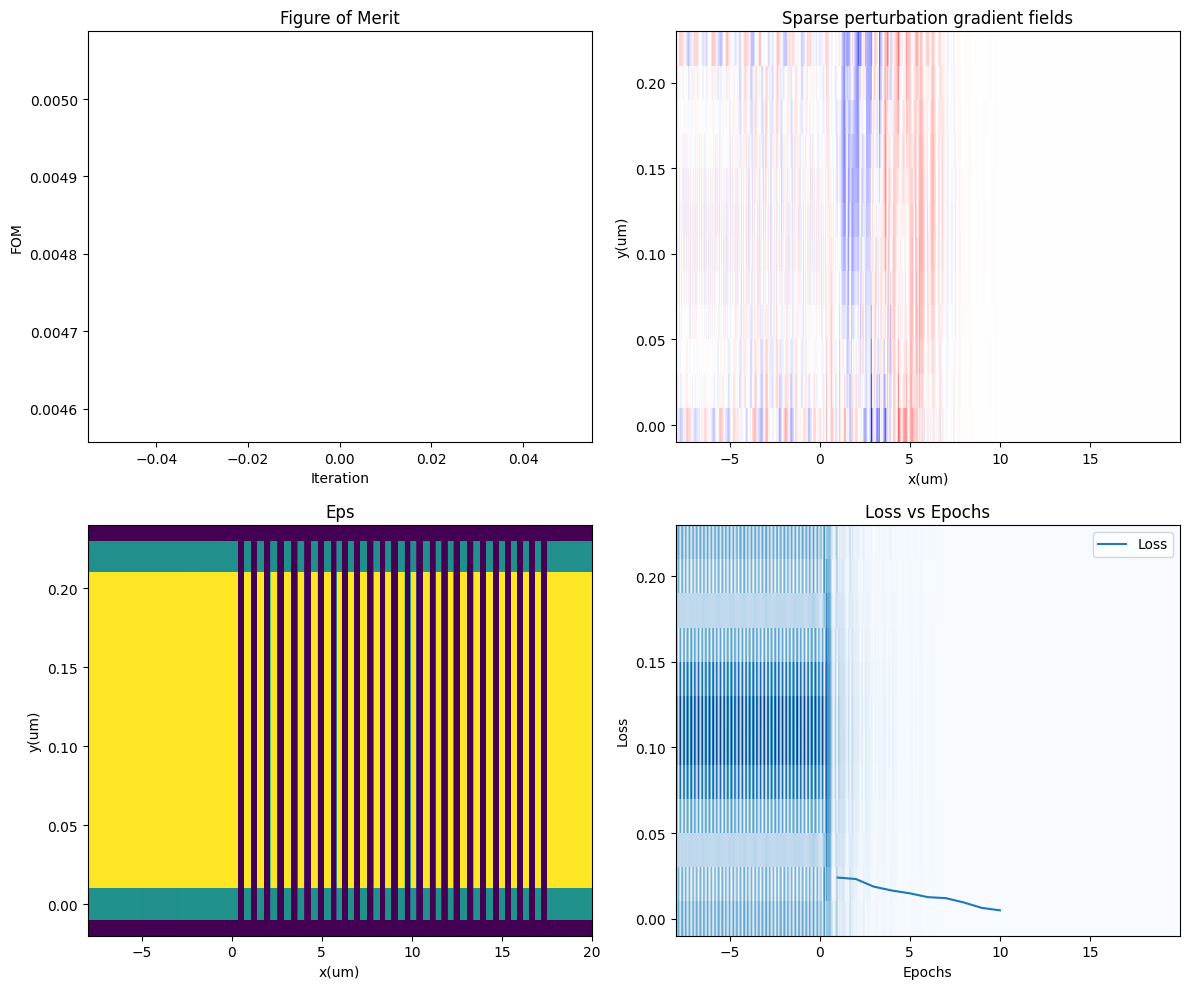

In [7]:
input_dim = 10
hidden_dim = 128
num_blocks = 4
output_dim = 50
num_choices=50

model = ResNetGenerator(input_dim, hidden_dim, num_blocks, output_dim, num_choices)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

loss_history = []

for epoch in range(epochs):
    
    model.train()
    optimizer.zero_grad()
    
    z = torch.randn(2, input_dim)

    normIter = epoch/epochs
    alpha = model.update_alpha(normIter)
    
    predicted_coords = model(z, alpha)

    for i in range(predicted_coords.size(0)):
        if i == 0:
            coords = predicted_coords[i]
            FoM, gradients = FDTD_Simulation(coords.detach().numpy())

            np.savetxt(f'fom.csv', [FoM], delimiter=',')
            np.savetxt(f'gradient.csv', gradients, delimiter=',')
        
    loss = lumerical_grad_pytorch(coords)

    loss_history.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        print(f'Coordinates: {coords}')

plt.plot(range(1, epochs + 1), loss_history, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.show()